# Essais IA - BDD signaux acceptables

In [1143]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import Fonctions_BDD_Signaux_Artificiels as BDD
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models

from scipy import signal
import scipy.io.wavfile as wav

In [1144]:
liste_comp = BDD.BDD_type('A')
# print(liste_comp)
# print(len(liste_comp))

liste_train = []
liste_test = []

for i in range(1,229):
    if i % 4 == 0 :
        liste_test.append(liste_comp[i-1])
    else :
        liste_train.append(liste_comp[i-1])

print("Liste complète", len(liste_comp))
print("75%", len(liste_train))
print("25%", len(liste_test))

Liste complète 228
75% 171
25% 57


### Définition des labels

In [1145]:
target_train = []
target_test = []

for i in range(0,43):
    target_train.append('Gendarmerie')
for i in range(43,86):
    target_train.append('Police')    
for i in range(86,129):
    target_train.append('Pompiers')
for i in range(129,171):
    target_train.append('Samu')

for i in range(0,14):
    target_test.append('Gendarmerie')
for i in range(14,28):
    target_test.append('Police')
for i in range(28,42):
    target_test.append('Pompiers')
for i in range(42,57):
    target_test.append('Samu')

print(len(target_train))
print(len(target_test))

171
57


### Mélange de la BDD

In [1146]:
liste_test_s, target_test_s = shuffle(liste_test, target_test)
liste_train_s, target_train_s = shuffle(liste_train, target_train)

### Définition de image_train et image_test

In [1147]:
def return_image(liste, path):
    d = 0
    L = np.zeros((len(liste), 41, 27))
    for j in range(0,len(liste)):
        sig = liste[j]
        sig = sig[0:18]+'.wav'

        fichier = path+'/'+sig
        Fe_vect, x = wav.read(fichier)
        
        fs = int(5e4)

        x_2 = np.reshape(x,(len(x)//fs,fs))
        for i in range(1,len(x_2[:,0])+1):
            sign = liste[j]
            if i == int(sign[18:20]):
                f, t, Sxx = signal.spectrogram(x_2[i-1,:], fs, nperseg=2048)
                Sxx_2 = Sxx[0 : len(Sxx[:,0])//5 , :]
                Sxx_3 = np.zeros((len(Sxx_2[:,0])//5, len(Sxx_2[0,:])))
                for h in range(0,len(Sxx_3[:,0])):
                    Sxx_3[h,:] = np.mean(Sxx_2[5*h : 5*(h+1) , :], axis = 0)
                L[d,:] = Sxx_3 
                d = d+1
    return L

In [1148]:
image_train = return_image(liste_train_s, r'C:\Users\leoca\Documents\Cours Master\PSia\sirenesIA\Sirenes artificielles')
image_test = return_image(liste_test_s, r'C:\Users\leoca\Documents\Cours Master\PSia\sirenesIA\Sirenes artificielles')
image_train = image_train[...,None]#Etape nécessaire à la detection des couleurs par les couches conv2D
image_test = image_test[...,None]#Same
print(image_train.shape)
print(image_test.shape)

(171, 41, 27, 1)
(57, 41, 27, 1)


### Encodage des label_train et label_test

In [1149]:
encodage = {"Gendarmerie":0, "Police":1, "Pompiers":2, "Samu":3}
sirenes_labels_numeriques_train = []
for label in target_train_s :
    sirenes_labels_numeriques_train.append(encodage[label])

sirenes_labels_numeriques_test = []
for label in target_test_s :
    sirenes_labels_numeriques_test.append(encodage[label])

In [1150]:
labels_train_onehot = tf.keras.utils.to_categorical(sirenes_labels_numeriques_train)
labels_test_onehot = tf.keras.utils.to_categorical(sirenes_labels_numeriques_test)

print(labels_train_onehot.shape)
print(labels_test_onehot.shape)

(171, 4)
(57, 4)


### IA test

In [1151]:
# On convertit nos valeurs en float

image_train = image_train.astype(float)
image_test = image_test.astype(float)

# On normalise les pixels pour avoir des valeurs entre 0 et 1

image_train = image_train/255
image_test = image_test/255

In [1152]:
model = tf.keras.models.Sequential()

In [1153]:
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(41, 27, 1)))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [1154]:
model.add(tf.keras.layers.Flatten())

In [1155]:
model.add(tf.keras.layers.Dense(400, activation="relu"))
model.add(tf.keras.layers.Dense(200, activation="relu"))
model.add(tf.keras.layers.Dense(4,activation="softmax"))

In [1156]:
model.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 39, 25, 64)        640       
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 19, 12, 64)        0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 17, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 8, 5, 128)         0         
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 6, 3, 64)          73792     
_________________________________________________________________
flatten_63 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_164 (Dense)            (None, 400)             

In [1157]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [1158]:
history = model.fit(image_train, labels_train_onehot,
                    epochs=20,
                    validation_split=0.1)

Epoch 1/20
5/5 [==============================] - 1s 71ms/step - loss: 8.7148 - accuracy: 0.2903 - val_loss: 2.7166 - val_accuracy: 0.3333
Epoch 2/20
5/5 [==============================] - 0s 35ms/step - loss: 2.4098 - accuracy: 0.2555 - val_loss: 1.3549 - val_accuracy: 0.2778
Epoch 3/20
5/5 [==============================] - 0s 36ms/step - loss: 1.4732 - accuracy: 0.3498 - val_loss: 1.4591 - val_accuracy: 0.2778
Epoch 4/20
5/5 [==============================] - 0s 36ms/step - loss: 1.2683 - accuracy: 0.4207 - val_loss: 1.3437 - val_accuracy: 0.2778
Epoch 5/20
5/5 [==============================] - 0s 39ms/step - loss: 1.1202 - accuracy: 0.6171 - val_loss: 1.2617 - val_accuracy: 0.4444
Epoch 6/20
5/5 [==============================] - 0s 33ms/step - loss: 0.9561 - accuracy: 0.6979 - val_loss: 1.2062 - val_accuracy: 0.4444
Epoch 7/20
5/5 [==============================] - 0s 35ms/step - loss: 0.7980 - accuracy: 0.6862 - val_loss: 1.1030 - val_accuracy: 0.4444
Epoch 8/20
5/5 [===========

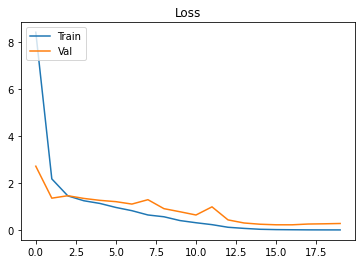

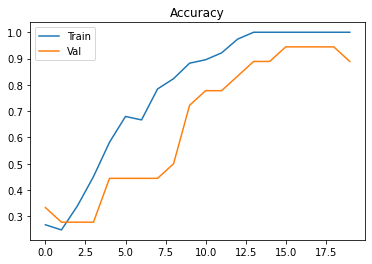

In [1159]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [1160]:
loss, acc = model.evaluate(image_test, labels_test_onehot)
print("Test Loss", loss)
print("Test Accuracy", acc)

2/2 [==============================] - 0s 9ms/step - loss: 0.1782 - accuracy: 0.9123
Test Loss 0.17815367877483368
Test Accuracy 0.9122806787490845
